# Model Comparison

In [1]:
import pandas
# from Code.PK_model import PintsPKLinIV as Pints_PK_model
# from Code.PD_model import PintsPDFribergLinE as Pints_PD_model
from Code.Profile_loglikelihood import profile_loglikelihood 
from Code.Likelihoods import MultiplicativeGaussianLogLikelihood, GaussianLogLikelihood, ConstantAndMultiplicativeGaussianLogLikelihood
import pints
# import pints.plot
import pints.io 
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import arviz as az
import scipy

In [2]:
drug = 'Docetaxel'
dose = 10.0
num_comp = 2
observation_name = 'Platelets '

## WAIC & PSIS-LOO

### Simulated Data

In [18]:
PD_actual_params = np.load("../Data_and_parameters/PD_sim/actual_params.npy")
PD_param_names = PD_actual_params[0]
PD_actual_params = PD_actual_params[1]
PD_actual_params = PD_actual_params.astype('float64')

df = pandas.read_csv("../Data_and_parameters/PD_sim/sythesised_data_real_timepoints.csv")
print(df)
observed = az.convert_to_inference_data(np.asarray(df['OBS']), group='observed_data')

        ID  DOSE   TIME          OBS
0      0.0   0.0  -48.0   996.613880
1      0.0   0.0   48.0  1093.703842
2      0.0   0.0  120.0   963.388943
3      0.0   0.0  192.0   708.445214
4      0.0   0.0  264.0   963.677974
..     ...   ...    ...          ...
475  314.0   3.0  192.0   746.021561
476  314.0   3.0  264.0  1295.751618
477  314.0   3.0  336.0  1852.455780
478  314.0   3.0  432.0   970.468193
479  314.0   3.0  552.0   954.674338

[480 rows x 4 columns]


In [19]:
model_types = ["add", "mult", "mult_noeta","comb", "comb_noeta"]
compare_dict = {}
data_type = 'real'

for model_type in model_types:
    
    samples = np.asarray(
        pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_'+model_type+'_samples_chain', n=3)
    )[:,-len(PD_actual_params)*2250:, :]
    pointwise = np.asarray(
        pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_'+model_type+'_pointloglike_chain', n=3)
    )[:,-len(PD_actual_params)*2250:, :]
    likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
    posterior = az.convert_to_inference_data(samples, group='posterior')
    
#     print('----------------------------------------------------------------------------------')
#     print(model_type)
#     print('----------------------------------------------------------------------------------')
#     print(pints.MCMCSummary(samples))
#     print('\n')
    
    inference_data = az.concat(likelihood, posterior, observed)
    compare_dict[model_type] = inference_data

In [5]:
compare_dict["add"]

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

In [20]:
comparison = az.compare(compare_dict)
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
mult,0,-3131.302884,4.554801,0.000000,9.194769e-01,15.465982,0.000000,False,log
comb,1,-3131.697384,4.549758,0.394500,8.052312e-02,15.402547,0.964644,False,log
comb_noeta,2,-3131.946601,4.856848,0.643717,0.000000e+00,15.348094,0.414251,False,log
mult_noeta,3,-3132.272442,4.626429,0.969558,1.802136e-14,15.499593,1.112527,False,log
add,4,-14196.536558,11053.638646,11065.233673,0.000000e+00,616.076197,612.764241,True,log


In [21]:
model_type = "mult_noeta"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


mult_noeta
	 z value = 0.8714915682807666
	 p value = 0.19174290385416004
add
	 z value = 18.057897212436036
	 p value = 3.418906567663547e-73


In [22]:
comparison = az.compare(compare_dict, ic="waic")
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
mult,0,-3131.299115,4.551031,0.000000,9.182848e-01,15.465612,0.000000,False,log
comb,1,-3131.691984,4.544358,0.392869,8.171523e-02,15.401959,0.964000,False,log
comb_noeta,2,-3131.937544,4.847790,0.638429,3.509570e-13,15.347124,0.415379,False,log
mult_noeta,3,-3132.268168,4.622155,0.969054,8.539744e-14,15.499021,1.112006,True,log
add,4,-16677.828090,13534.930178,13546.528975,0.000000e+00,1957.887957,1954.092315,True,log


In [23]:
model_type = "mult_noeta"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


mult_noeta
	 z value = 0.8714465603850907
	 p value = 0.19175518628968335
add
	 z value = 6.9323894629295895
	 p value = 2.0689542768287893e-12


### Pharmaceutical Data

In [10]:
df = pandas.read_csv("../Data_and_parameters/PD_real/data_refined_"+drug+"_"+observation_name+".csv")
observed = az.convert_to_inference_data(np.asarray(df['OBS']), group='observed_data')

In [11]:
model_types = {
    "add": "Constant noise",
#     "mult" : "Relative noise",
    "mult_noeta" : "Relative noise, Fixed eta",
#     "comb" : "Combined noise",
#     "comb_noeta" : "Combined noise, Fixed eta"
}
compare_dict = {}
data_type = 'real'

for model_type in model_types:
    samples = np.asarray(pints.io.load_samples(
        '../Data_and_parameters/PD_real/MCMC_'+model_type+'_samples_chain', 
        n=3
    ))[:,-len(PD_actual_params)*2250:, :]
    pointwise = np.asarray(pints.io.load_samples(
        '../Data_and_parameters/PD_real/MCMC_'+model_type+'_pointloglike_chain', 
        n=3
    ))[:,-len(PD_actual_params)*2250:, :]
    likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
    posterior = az.convert_to_inference_data(samples, group='posterior')
    
    inference_data = az.concat(likelihood, posterior, observed)
    compare_dict[model_types[model_type]] = inference_data


In [12]:
compare_dict["Constant noise"]

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

In [13]:
comparison = az.compare(compare_dict)
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/pytho

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Constant noise,0,-2379.147462,6.541652,0.000000,0.887717,18.200422,0.000000,False,log
"Relative noise, Fixed eta",1,-2391.056726,6.955424,11.909264,0.112283,19.857641,6.802181,False,log


In [14]:
model_type = model_types["mult_noeta"]
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = model_types["add"]0.0
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


Relative noise, Fixed eta
	 z value = 1.7508007174656943
	 p value = 0.03999012149451271
Constant noise
	 z value = nan
	 p value = nan


<ipython-input-14-b5e68c8094a0>:9: RuntimeWarning: invalid value encountered in double_scalars
  z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]


In [15]:
comparison = az.compare(compare_dict, ic="waic")
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Constant noise,0,-2379.148144,6.542334,0.000000,0.887337,18.201972,0.000000,True,log
"Relative noise, Fixed eta",1,-2391.023187,6.921885,11.875043,0.112663,19.853158,6.796133,True,log


In [17]:
model_type = model_types["mult_noeta"]
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = model_types["add"]
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


Relative noise, Fixed eta
	 z value = 1.7473235470651465
	 p value = 0.04029061539973705
Constant noise
	 z value = nan
	 p value = nan


<ipython-input-17-c16080cacdbc>:9: RuntimeWarning: invalid value encountered in double_scalars
  z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]


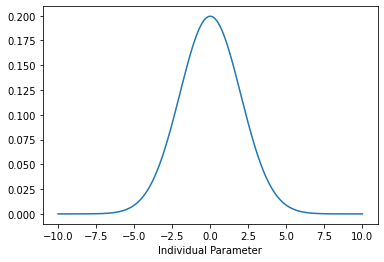

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-10, 10, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,0,2))
plt.xlabel("Individual Parameter")

plt.savefig("normal_dist_ind.svg")
plt.show()